# 01 - Data Exploration

Vesuvius Surface Detection dataset'ini inceleme.

In [33]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tifffile

from src.utils.config import get_config

cfg = get_config()
print(f"Config loaded from: {cfg._root}")

Config loaded from: /Users/enesdemir/Documents/Vesuvius_Challenge_Surface_Detection


## 1. CSV Yükleme

In [34]:
# Train CSV
train_csv_path = cfg.path('train_csv')
train_df = pd.read_csv(train_csv_path)
train_df['id'] = train_df['id'].astype(str)

print(f"Train CSV: {train_csv_path}")
print(f"Total volumes in CSV: {len(train_df)}")
train_df.head(10)

Train CSV: /Users/enesdemir/Documents/Vesuvius_Challenge_Surface_Detection/dataset/raw/train.csv
Total volumes in CSV: 806


,id,scroll_id
0,1407735,26002
1,2290837,34117
2,3320274,35360
3,8862040,34117
4,11460685,34117
5,11630450,34117
6,15307632,34117
7,17283971,34117
8,19797301,26010
9,26894125,26002


In [35]:
# Test CSV
test_csv_path = cfg.path('test_csv')
test_df = pd.read_csv(test_csv_path)
test_df['id'] = test_df['id'].astype(str)

print(f"Test CSV: {test_csv_path}")
print(f"Total volumes in CSV: {len(test_df)}")
test_df.head()

Test CSV: /Users/enesdemir/Documents/Vesuvius_Challenge_Surface_Detection/dataset/raw/test.csv
Total volumes in CSV: 1


,id,scroll_id
0,1407735,26002


## 2. Eksik Dosya Kontrolü

CSV'deki her ID için image ve label dosyalarının varlığını kontrol et.

In [36]:
# Paths
train_images_dir = cfg.path('train_images')
train_labels_dir = cfg.path('train_labels')

print(f"Train images dir: {train_images_dir}")
print(f"Train labels dir: {train_labels_dir}")

Train images dir: /Users/enesdemir/Documents/Vesuvius_Challenge_Surface_Detection/dataset/raw/train_images
Train labels dir: /Users/enesdemir/Documents/Vesuvius_Challenge_Surface_Detection/dataset/raw/train_labels


In [37]:
# Check missing images and labels
missing_images = []
missing_labels = []
valid_ids = []

for vol_id in train_df['id']:
    img_path = train_images_dir / f"{vol_id}.tif"
    lbl_path = train_labels_dir / f"{vol_id}.tif"
    
    if not img_path.exists():
        missing_images.append(vol_id)
    else:
        valid_ids.append(vol_id)
        if not lbl_path.exists():
            missing_labels.append(vol_id)

print(f"\n=== Summary ===")
print(f"Total in CSV: {len(train_df)}")
print(f"Valid (has image): {len(valid_ids)}")
print(f"Missing images: {len(missing_images)}")
print(f"Missing labels (but has image): {len(missing_labels)}")

if missing_images:
    print(f"\nMissing image IDs (first 10): {missing_images[:10]}")


=== Summary ===
Total in CSV: 806
Valid (has image): 786
Missing images: 20
Missing labels (but has image): 0

Missing image IDs (first 10): ['1407735', '808135176', '862434992', '885379642', '1641318781', '1924200298', '1951193117', '2075542469', '2268221981', '2376256768']


In [38]:
# Filter dataframe to only valid IDs
valid_df = train_df[train_df['id'].isin(valid_ids)].copy()
print(f"Valid dataset size: {len(valid_df)}")

Valid dataset size: 786


## 3. Scroll ID Dağılımı

In [39]:
# Scroll distribution
scroll_counts = valid_df['scroll_id'].value_counts().sort_index()
print("Scroll ID distribution:")
print(scroll_counts)
print(f"\nTotal scrolls: {len(scroll_counts)}")

Scroll ID distribution:
scroll_id
26002     82
26010    129
34117    376
35360    170
44430     16
53997     13
Name: count, dtype: int64

Total scrolls: 6


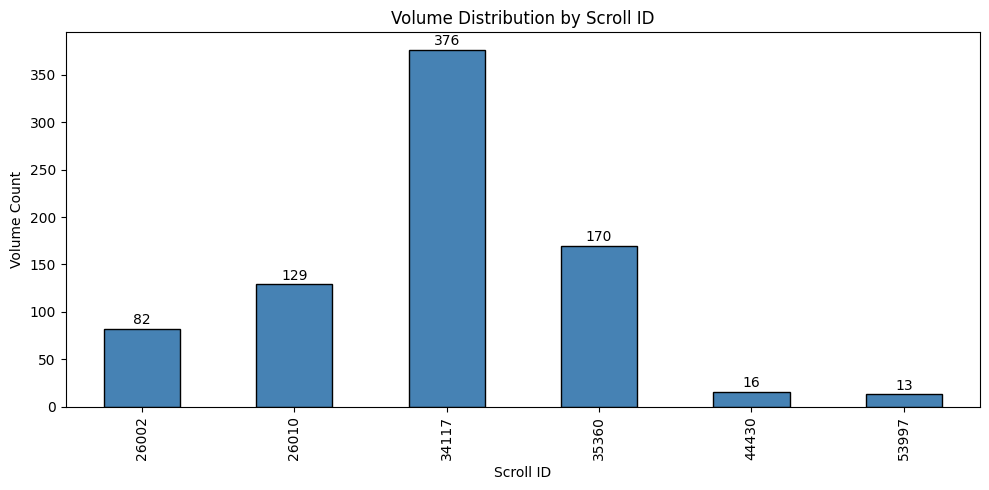

In [40]:
# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
scroll_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Scroll ID')
ax.set_ylabel('Volume Count')
ax.set_title('Volume Distribution by Scroll ID')

# Add count labels
for i, v in enumerate(scroll_counts.values):
    ax.text(i, v + 5, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [41]:
# Percentage distribution
scroll_pct = (scroll_counts / scroll_counts.sum() * 100).round(1)
print("Percentage distribution:")
for sid, pct in scroll_pct.items():
    print(f"  Scroll {sid}: {pct}% ({scroll_counts[sid]} volumes)")

Percentage distribution:
  Scroll 26002: 10.4% (82 volumes)
  Scroll 26010: 16.4% (129 volumes)
  Scroll 34117: 47.8% (376 volumes)
  Scroll 35360: 21.6% (170 volumes)
  Scroll 44430: 2.0% (16 volumes)
  Scroll 53997: 1.7% (13 volumes)


## 4. Volume Boyutları (Çözünürlük)

In [42]:
# Sample a few volumes to check resolution
sample_ids = valid_df['id'].sample(min(5, len(valid_df)), random_state=42).tolist()

print("Sample volume shapes:")
shapes = []
dtypes = []

for vol_id in sample_ids:
    img_path = train_images_dir / f"{vol_id}.tif"
    img = tifffile.imread(img_path)
    shapes.append(img.shape)
    dtypes.append(img.dtype)
    print(f"  {vol_id}: shape={img.shape}, dtype={img.dtype}, size={img.nbytes/1e6:.1f}MB")

Sample volume shapes:
  4109320911: shape=(320, 320, 320), dtype=uint8, size=32.8MB
  193365288: shape=(320, 320, 320), dtype=uint8, size=32.8MB
  1113943087: shape=(320, 320, 320), dtype=uint8, size=32.8MB
  1013184726: shape=(320, 320, 320), dtype=uint8, size=32.8MB
  1238390590: shape=(320, 320, 320), dtype=uint8, size=32.8MB


In [43]:
# Check if all shapes are the same
unique_shapes = set(shapes)
unique_dtypes = set(dtypes)

print(f"\nUnique shapes in sample: {unique_shapes}")
print(f"Unique dtypes in sample: {unique_dtypes}")

if len(unique_shapes) == 1:
    shape = list(unique_shapes)[0]
    print(f"\nAll sampled volumes have the same shape: {shape}")
    print(f"Total voxels per volume: {np.prod(shape):,}")


Unique shapes in sample: {(320, 320, 320)}
Unique dtypes in sample: {dtype('uint8')}

All sampled volumes have the same shape: (320, 320, 320)
Total voxels per volume: 32,768,000


## 5. Label Değerleri Kontrolü

In [44]:
# Check label values in a sample
sample_id = valid_df['id'].iloc[0]
lbl_path = train_labels_dir / f"{sample_id}.tif"

if lbl_path.exists():
    label = tifffile.imread(lbl_path)
    unique_vals = np.unique(label)
    
    print(f"Sample label: {sample_id}")
    print(f"Shape: {label.shape}")
    print(f"Dtype: {label.dtype}")
    print(f"Unique values: {unique_vals}")
    print(f"\nLabel encoding from config:")
    print(f"  Background: {cfg.data.label_encoding.background}")
    print(f"  Foreground: {cfg.data.label_encoding.foreground}")
    print(f"  Unlabeled: {cfg.data.label_encoding.unlabeled}")

Sample label: 2290837
Shape: (320, 320, 320)
Dtype: uint8
Unique values: [0 1 2]

Label encoding from config:
  Background: 0
  Foreground: 1
  Unlabeled: 2


In [45]:
# Class distribution in sample label
if lbl_path.exists():
    vals, counts = np.unique(label, return_counts=True)
    total = counts.sum()
    
    print("Class distribution in sample label:")
    for v, c in zip(vals, counts):
        label_name = {0: 'background', 1: 'foreground', 2: 'unlabeled'}.get(v, f'unknown({v})')
        print(f"  {label_name}: {c:,} voxels ({c/total*100:.2f}%)")

Class distribution in sample label:
  background: 12,229,727 voxels (37.32%)
  foreground: 1,597,571 voxels (4.88%)
  unlabeled: 18,940,702 voxels (57.80%)


## 6. Özet

In [46]:
print("="*50)
print("DATASET SUMMARY")
print("="*50)
print(f"Total volumes in CSV: {len(train_df)}")
print(f"Valid volumes (with images): {len(valid_ids)}")
print(f"Missing images (deprecated): {len(missing_images)}")
print(f"Missing labels: {len(missing_labels)}")
print(f"\nNumber of scrolls: {len(scroll_counts)}")
print(f"Scroll IDs: {sorted(scroll_counts.index.tolist())}")
print(f"\nVolume shape: {shapes[0] if shapes else 'N/A'}")
print(f"Volume dtype: {dtypes[0] if dtypes else 'N/A'}")
print(f"\nLabel values: 0=background, 1=foreground, 2=unlabeled")
print(f"\nConfig train/val split:")
print(f"  val_ratio: {cfg.data.val_ratio}")
print(f"  seed: {cfg.data.seed}")

DATASET SUMMARY
Total volumes in CSV: 806
Valid volumes (with images): 786
Missing images (deprecated): 20
Missing labels: 0

Number of scrolls: 6
Scroll IDs: [26002, 26010, 34117, 35360, 44430, 53997]

Volume shape: (320, 320, 320)
Volume dtype: uint8

Label values: 0=background, 1=foreground, 2=unlabeled

Config train/val split:
  val_ratio: 0.2
  seed: 42
